Pronósticos de series de tiempo del IPSA con PROPHET

Introducción:

Facebook ha puesto como código abierto su herramienta de pronóstico Prophet, diseñada "para que sea más fácil para los expertos y no expertos hacer pronósticos de alta calidad”, de acuerdo a una entrada de blog de Sean J. Taylor y Ben Letham del equipo de investigación de la empresa. "Los pronósticos son personalizables en formas que son intuitivas para los usuarios no expertos”.

Algunas características de Prophet:

<ul>
<li>observaciones por hora, diarias o semanales con al menos algunos meses (preferiblemente un año) de historia</li>
<li>Estacionales múltiples y fuertes a "escala humana": día de la semana y época del año</li>
<li>Días festivos importantes que ocurren a intervalos irregulares que se conocen de antemano (por ejemplo, el Super Bowl)</li>
<li>Un número razonable de observaciones faltantes o grandes valores atípicos</li>
<li>Cambios históricos de tendencia, por ejemplo, debido a lanzamientos de productos o cambios de registro</li>
<li>Tendencias que son curvas de crecimiento no lineales, donde una tendencia alcanza un límite natural o satura</li>
</ul> 

¿Que es el IPSA?

El IPSA (Índice de Precio Selectivo de Acciones) es el principal índice bursátil de Chile, elaborado por la Bolsa de Comercio de Santiago. Corresponde a un indicador de [[rentabilidad financiera|rentabilidad de las 40 acciones con mayor presencia bursátil, siendo dicha lista revisada anualmente. En su cálculo el índice considera todas las variaciones de capital de cada acción incluida en el índice, ponderada por el peso relativo de cada una de ellas, siendo dicho peso calculado a partir de una fórmula que considera, tanto la capitalización bursátil, como el número de transacciones y el free float.

El IPSA es calculado desde el año 1977, estando en un primer momento (hasta 1980) separado en dos índices, uno de acciones con alta presencia (mayor a 75%) y aquellas de baja presencia (entre 30% y 75%).

Hasta el año 2002 el IPSA se calculaba utilizando como base (100) el nivel del índice a principios de cada año, siendo modificadas las empresas que lo componían de manera trimestral. A partir del año 2003,las acciones componentes del IPSA son establecidas el 31 de diciembre de cada año y se utiliza como base (1.000) dicho día.


In [109]:
# Importar Librerias necesarias para el proyecto
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from fbprophet import Prophet
import statsmodels.api as sm
from scipy import stats
from pandas.core import datetools
from plotly import tools
import plotly.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import warnings
warnings.filterwarnings("ignore")

plt.style.use("seaborn-whitegrid")

In [110]:
#Cargamos el data set de IPSA
df = pd.read_csv("dataset/IPSA.csv", encoding = "ISO-8859-1", sep=',')
df.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-05-14,4279.810059,4296.419922,4279.810059,4288.950195,4288.950195,0
1,2013-05-15,4290.240234,4303.620117,4280.259766,4286.319824,4286.319824,0
2,2013-05-16,4292.089844,4300.020020,4257.970215,4261.200195,4261.200195,0
3,2013-05-17,4265.700195,4269.819824,4243.629883,4258.979980,4258.979980,0
4,2013-05-20,4262.220215,4269.450195,4226.339844,4233.140137,4233.140137,0


In [111]:
df.describe()

,Date,Open,High,Low,Close,Adj Close,Volume
count,1246,1246,1246,1246,1246,1246,1246
unique,1246,1232,1237,1231,1233,1233,2
top,2013-06-19,null,null,null,null,null,0
freq,1,6,6,6,6,6,1240


In [112]:
df_null = df[df.isnull().any(axis=1)]
df_null.head()

,Date,Open,High,Low,Close,Adj Close,Volume


In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1246 entries, 0 to 1245
Data columns (total 7 columns):
Date         1246 non-null object
Open         1246 non-null object
High         1246 non-null object
Low          1246 non-null object
Close        1246 non-null object
Adj Close    1246 non-null object
Volume       1246 non-null object
dtypes: object(7)
memory usage: 68.2+ KB


In [114]:
#Creamos una copia del dataframe
#eliminamos las filas en null
df.drop(399, inplace=True)
df.drop(400, inplace=True)
df.drop(401, inplace=True)
df.drop(402, inplace=True)
df.drop(655, inplace=True)
df.drop(983, inplace=True)
df_copia = df.copy()



In [115]:
print(df_copia.to_string())

            Date         Open         High          Low        Close    Adj Close Volume
0     2013-05-14  4279.810059  4296.419922  4279.810059  4288.950195  4288.950195      0
1     2013-05-15  4290.240234  4303.620117  4280.259766  4286.319824  4286.319824      0
2     2013-05-16  4292.089844  4300.020020  4257.970215  4261.200195  4261.200195      0
3     2013-05-17  4265.700195  4269.819824  4243.629883  4258.979980  4258.979980      0
4     2013-05-20  4262.220215  4269.450195  4226.339844  4233.140137  4233.140137      0
5     2013-05-22  4237.060059  4274.000000  4228.689941  4270.120117  4270.120117      0
6     2013-05-23  4262.000000  4262.000000  4228.089844  4237.040039  4237.040039      0
7     2013-05-24  4236.850098  4240.720215  4195.189941  4197.290039  4197.290039      0
8     2013-05-27  4199.680176  4207.040039  4169.609863  4171.250000  4171.250000      0
9     2013-05-28  4173.810059  4196.350098  4137.770020  4138.879883  4138.879883      0
10    2013-05-29  414

In [116]:
df_copia.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1240 entries, 0 to 1245
Data columns (total 7 columns):
Date         1240 non-null object
Open         1240 non-null object
High         1240 non-null object
Low          1240 non-null object
Close        1240 non-null object
Adj Close    1240 non-null object
Volume       1240 non-null object
dtypes: object(7)
memory usage: 77.5+ KB


In [117]:
#Cambiamos el tipo de datos de las columnas a Date y numeric
df_copia.loc[:,'Date']  = pd.to_datetime(df.loc[:,'Date'], format ='%Y/%m/%d')
df_copia.loc[:,'Close']  = pd.to_numeric(df.loc[:,'Close'])
df_copia.loc[:,'High']  = pd.to_numeric(df.loc[:,'High'])
df_copia.loc[:,'Low']  = pd.to_numeric(df.loc[:,'Low'])
df_copia.loc[:,'Adj Close']  = pd.to_numeric(df.loc[:,'Adj Close'])
df_copia.loc[:,'Volume']  = pd.to_numeric(df.loc[:,'Volume'])

In [118]:
df_copia.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1240 entries, 0 to 1245
Data columns (total 7 columns):
Date         1240 non-null datetime64[ns]
Open         1240 non-null object
High         1240 non-null float64
Low          1240 non-null float64
Close        1240 non-null float64
Adj Close    1240 non-null float64
Volume       1240 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 77.5+ KB


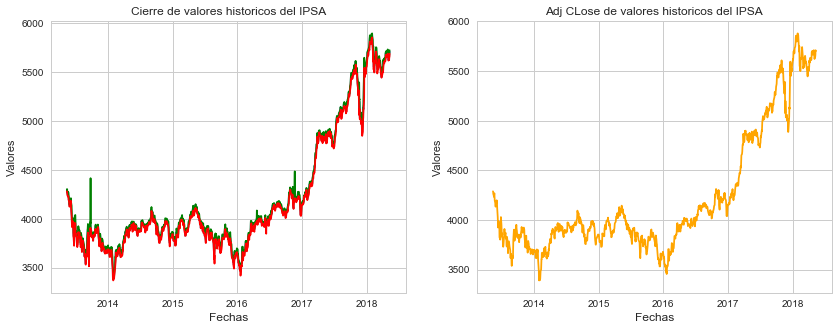

In [119]:
#Grafico de las variables del IPSA()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
ax1.plot(df_copia["Date"], df_copia["Close"])
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Valores")
ax1.set_title("Cierre de valores historicos del IPSA")

# Segundo grafico 

ax1.plot(df_copia["Date"], df_copia["High"], color="green")
ax1.set_xlabel("Fechas", fontsize=12)
ax1.set_ylabel("Stock Price")
#ax1.set_title("High de precios historicos IPSA")

# Tercer grafico
ax1.plot(df_copia["Date"], df_copia["Low"], color="red")
ax1.set_xlabel("Fechas", fontsize=12)
ax1.set_ylabel("Valores")
#ax1.set_title("Low de precios historicos IPSA")

# Cuarto grafico
ax2.plot(df_copia["Date"], df_copia["Adj Close"], color="orange")
ax2.set_xlabel("Fechas", fontsize=12)
ax2.set_ylabel("Valores")
ax2.set_title("Adj CLose de valores historicos del IPSA")
plt.show()


Introducción a Prophet:
Prophet es la biblioteca de Facebook para la previsión de series de tiempo. 

Pasos para usar Prophet:

Ajuste ese marco de datos a Prophet para detectar patrones futuros.
Predecir los precios superiores e inferiores del precio de cierre.

In [120]:
m = Prophet()
# Dejar solo las columnas close y Date
df_copia = df_copia.drop(['Open', 'High', 'Low','Volume','Adj Close'], axis=1)
df_copia.rename(columns={'Close': 'y', 'Date': 'ds'}, inplace=True)

df_copia.head()

,ds,y
0,2013-05-14,4288.950195
1,2013-05-15,4286.319824
2,2013-05-16,4261.200195
3,2013-05-17,4258.979980
4,2013-05-20,4233.140137


In [121]:
m = Prophet()

m.fit(df_copia)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [122]:
# Creacion de fechas futuras
future_prices = m.make_future_dataframe(periods=365)

# Predecir los valores futuros
forecast = m.predict(future_prices)
#Con .tail() se muestran los ultimos registros creados de la predicción
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1600,2019-05-07,6887.573554,6410.709257,7344.722591
1601,2019-05-08,6893.042394,6413.543548,7374.056242
1602,2019-05-09,6899.677854,6430.373031,7360.757622
1603,2019-05-10,6909.973718,6409.298368,7384.067193
1604,2019-05-11,7039.798762,6556.541819,7497.493602


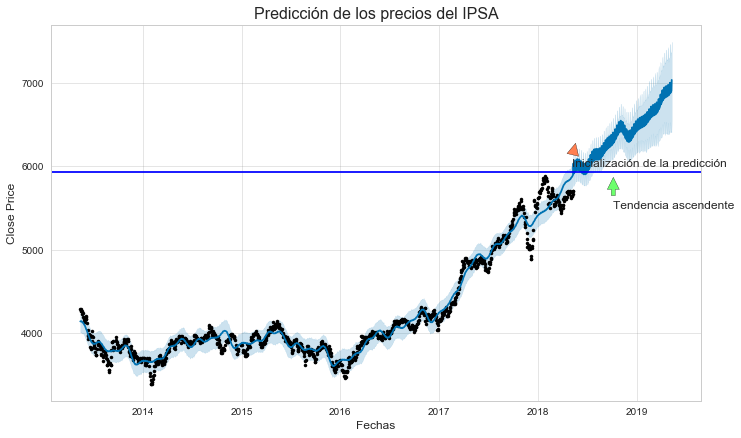

In [123]:
import matplotlib.dates as mdates

# Fechas
starting_date = dt.datetime(2018, 5, 7)
starting_date1 = mdates.date2num(starting_date)
trend_date = dt.datetime(2018, 10, 7)
trend_date1 = mdates.date2num(trend_date)

pointing_arrow = dt.datetime(2018, 5, 22)
pointing_arrow1 = mdates.date2num(pointing_arrow)

fig = m.plot(forecast)
ax1 = fig.add_subplot(111)
ax1.set_title("Predicción de los precios del IPSA", fontsize=16)
ax1.set_xlabel("Fechas", fontsize=12)
ax1.set_ylabel("Close Price", fontsize=12)

ax1.annotate('Inicialización de la predicción', xy=(pointing_arrow1, 6300), xytext=(starting_date1,6000),
            arrowprops=dict(facecolor='#ff7f50', shrink=0.1),
            )

ax1.annotate('Tendencia ascendente', xy=(trend_date1, 5900), xytext=(trend_date1,5500),
            arrowprops=dict(facecolor='#6cff6c', shrink=0.1),
            )

ax1.axhline(y=5930, color='b', linestyle='-')

plt.show()

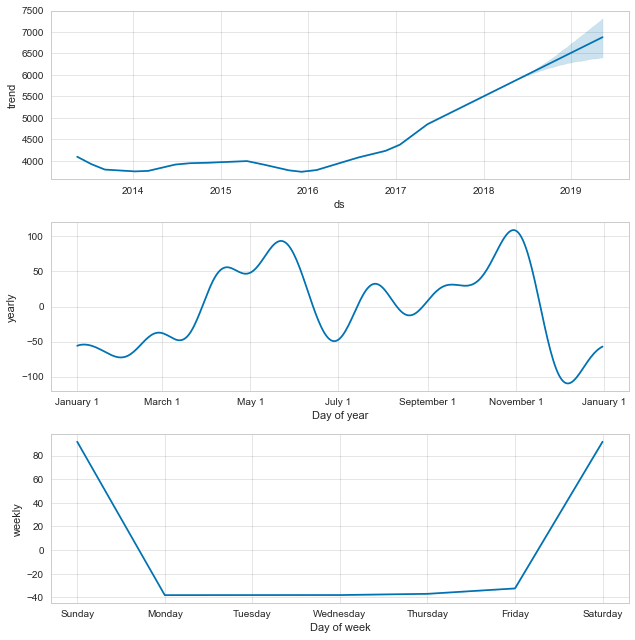

In [124]:
fig2 = m.plot_components(forecast)
plt.show()

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


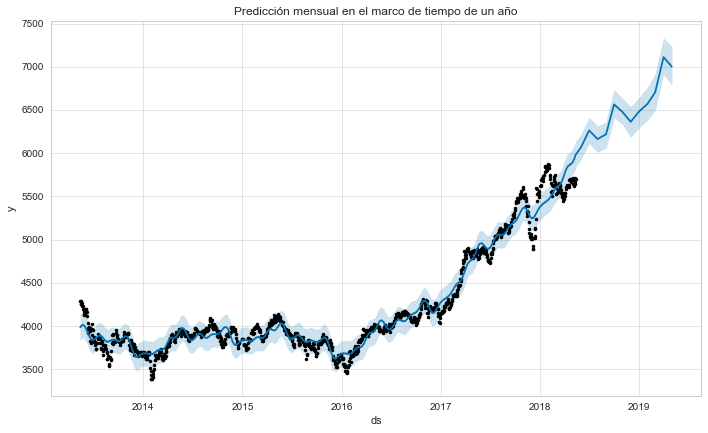

In [125]:
# Predicciones mensuales
m = Prophet(changepoint_prior_scale=0.01).fit(df_copia)
future = m.make_future_dataframe(periods=12, freq='M')
fcst = m.predict(future)
fig = m.plot(fcst)
plt.title("Predicción mensual en el marco de tiempo de un año")

plt.show()

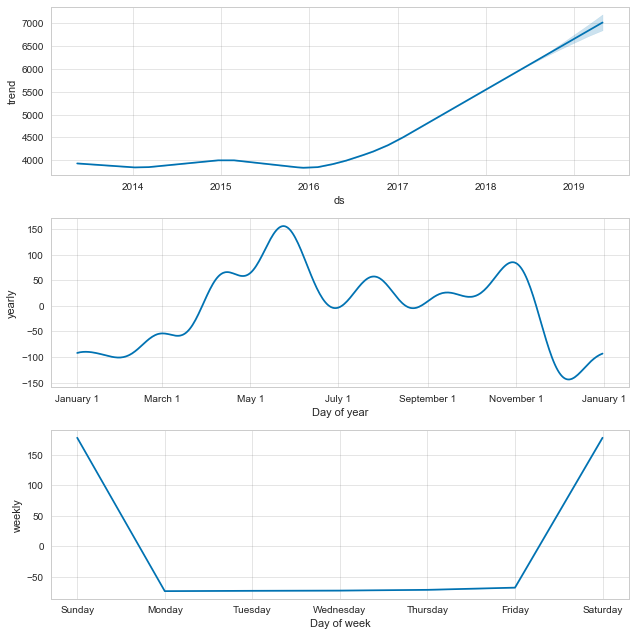

In [126]:
fig = m.plot_components(fcst)
plt.show()

Con los datos que tenemos, es difícil ver qué tan bueno / malo se compara el pronóstico (línea azul) con los datos reales (puntos negros). Echemos un vistazo a los últimos 800 puntos de datos (~ 2 años) de pronóstico vs real sin mirar el pronóstico futuro (porque solo estamos interesados en obtener una imagen del error entre el pronóstico real frente al pronóstico).

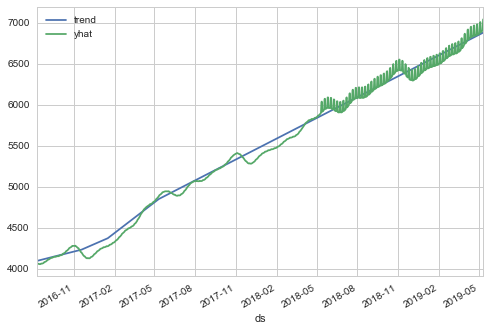

In [137]:
dos_anos = forecast.set_index('ds').join(df)
dos_anos = dos_anos[['trend','yhat','yhat_upper','yhat_lower']].dropna().tail(800)

#dos_anos['yhat'] = np.exp(dos_anos.yhat)
#dos_anos['yhat_upper'] = np.exp(dos_anos.yhat_upper)
#dos_anos['yhat_lower'] = np.exp(dos_anos.yhat_lower)
dos_anos[['trend','yhat']].plot()
plt.show()

Como puede ver en el gráfico anterior, nuestro pronóstico sigue la tendencia bastante bien, pero no parece tan bueno para captar la "volatilidad" del mercado. Sin embargo esto puede ser bueno si estamos interesados en "montar la tendencia" en lugar de tratar de atrapar picos y caídas perfectamente.

Ahora veremos algunas medidas de precisión. En primer lugar, veremos una función básica de descripción del cuadro de datos de pandas para ver cómo se ve la cosa, luego veremos el R cuadrado, el error medio cuadrático (MSE) y el error absoluto medio (MAE).

In [128]:
dos_anos_ae = (dos_anos.yhat - dos_anos.trend )
dos_anos_ae.describe()

count    800.000000
mean     -21.897996
std       72.050387
min     -147.464644
25%      -82.943335
50%      -18.952015
75%       20.523501
max      198.635589
dtype: float64

Esos realmente no son malos números, pero realmente no cuentan toda la historia. Veamos algunas medidas más de precisión.

Ahora, veamos R-squared usando la función sklearn sr2_score:

In [129]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

r2_score(dos_anos.trend, dos_anos.yhat)

0.99208036290755286

Obtenemos un valor de 0.99, que no está nada mal. Tomaré un valor de 0.9 en cualquier enfoque de modelado de primera vuelta.

Ahora, veamos el error cuadrático medio usando la función skarn_mean_squared_error:

In [130]:
mean_squared_error(dos_anos.trend, dos_anos.yhat)

5664.2914779884086

Obtenemos un valor de 5664.2914779884086

Un MSE de 5664.29 para un modelo que intenta predecir el IPSA con valores entre 3500 y 7500 no es tan bueno (recuerde ... para MSE, más cerca de cero es mejor) si está tratando de predecir cambios exactos y movimientos hacia arriba / abajo .

Ahora, veamos el error absoluto medio (MAE) usando la función mean_absolute_error de sklearn. El MAE es la medida del error absoluto entre dos variables continuas y puede darnos una mejor idea de las tasas de error que la media estándar.

In [131]:
mean_absolute_error(dos_anos.trend, dos_anos.yhat)

61.12574663959942

El MAE continúa diciéndonos que el pronóstico de profeta no es ideal para usar este pronóstico en el comercio.

Otra forma de ver la utilidad de este pronóstico es trazar las bandas de confianza superior e inferior del pronóstico contra los valores reales. Puedes hacer eso trazando yhat_upper y yhat_lower.

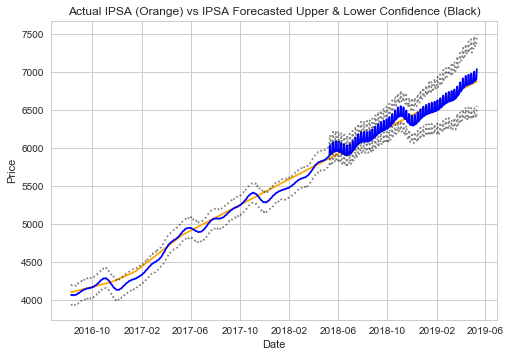

In [132]:
fig, ax4 = plt.subplots()
ax4.plot(dos_anos.trend, color='orange')
ax4.plot(dos_anos.yhat, color='blue')
ax4.plot(dos_anos.yhat_upper, color='black',  linestyle=':', alpha=0.5)
ax4.plot(dos_anos.yhat_lower, color='black',  linestyle=':', alpha=0.5)

ax4.set_title('Actual IPSA (Orange) vs IPSA Forecasted Upper & Lower Confidence (Black)')
ax4.set_ylabel('Price')
ax4.set_xlabel('Date')
plt.show()

En el gráfico de arriba, podemos ver el pronóstico (en azul) frente a los reales (en naranja) con las bandas de confianza superior e inferior en gris.

Realmente no se puede decir nada cuantificable de este cuadro, pero se puede hacer un juicio sobre el valor del pronóstico. Si está tratando de operar a corto plazo (de 1 día a unas pocas semanas), esta previsión es casi inútil, pero si está invirtiendo con un período de meses o años, esta previsión puede proporcionar algún valor para comprender mejor la tendencia del mercado y la tendencia pronosticada

Regresemos y miremos el pronóstico real para ver si podría decirnos algo diferente al pronóstico frente a los datos reales.


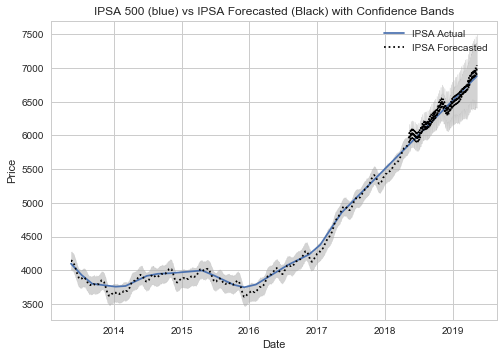

In [133]:
full_df = forecast.set_index('ds').join(df)
#full_df['yhat']=np.exp(full_df['yhat'])
 
fig, ax8 = plt.subplots()
ax8.plot(full_df.trend)
ax8.plot(full_df.yhat, color='black', linestyle=':')
ax8.fill_between(full_df.index, full_df['yhat_upper'], full_df['yhat_lower'], alpha=0.5, color='darkgray')
ax8.set_title('IPSA 500 (blue) vs IPSA Forecasted (Black) with Confidence Bands')
ax8.set_ylabel('Price')
ax8.set_xlabel('Date')
 
L=ax8.legend() #get the legend
L.get_texts()[0].set_text('IPSA Actual') 
L.get_texts()[1].set_text('IPSA Forecasted')
plt.show()

Este cuadro es un poco más fácil de entender que el gráfico profético predeterminado (al menos en mi opinión). Podemos ver a lo largo de la historia de los hechos en comparación con el pronóstico, que prophet hace un pronóstico de trabajo correcto pero tiene problemas con las áreas cuando el mercado se vuelve muy volátil.

Mirando específicamente el pronóstico futuro, prophet nos está diciendo que el mercado va a seguir subiendo y debería estar alrededor de 7000 al final del período de pronóstico, con bandas de confianza que se extienden desde 6200 a 7400. Si muestra este pronóstico a cualquier operador / inversor serio, rápidamente lo ignoraría como un pronóstico terrible. Cualquier cosa que tenga un intervalo de confianza de 1200 puntos no tiene valor en el mundo de la inversión a corto y largo plazo.